# 10. Full Analysis: A Higgs-Like Search

**Pedagogical context.** This notebook brings together every technique
developed in the preceding nine notebooks into a single, complete
analysis chain. The scenario is a search for a resonance decaying to
two photons, loosely modelled on the $H \to \gamma\gamma$ discovery
channel. The analysis uses a signal region where the resonance appears
as a bump over a smoothly falling continuum, and a background-enriched
control region that constrains the dominant systematic uncertainty on
the background normalisation.

The workflow follows the standard sequence used in LHC searches: build
the model (Notebooks 2 and 3), fit the data (Notebook 4), test for
discovery (Notebook 5), set upper limits (Notebooks 6 and 7), scan the
likelihood (Notebook 8), and inspect the diagnostics (Notebook 9). The
material corresponds to the capstone exercises in Cowan's TAE practical
sessions and to the full-chain examples in ATLAS and CMS analysis
tutorials.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from histimator.parameters import Parameter
from histimator.histograms import Histogram
from histimator.samples import Sample
from histimator.channels import Channel
from histimator.model import Model
from histimator.likelihood import fit
from histimator.inference import discovery_significance
from histimator.test_statistics import compute_q0, pvalue_q0
from histimator.cls import (
    build_asimov_model, cls_observed, cls_expected_band, upper_limit_cls
)
from histimator.scans import (
    likelihood_scan_1d, likelihood_scan_2d, scan_intervals, goodness_of_fit
)
from histimator.diagnostics import (
    prefit_postfit_yields, nuisance_parameter_pulls, impacts
)

## 10.1 Defining the analysis

The diphoton invariant mass spectrum is binned from 100 to 180 GeV in
10 GeV bins. The signal template peaks around 125 GeV, and the
background falls roughly exponentially. The control region is a sideband
where the signal contamination is negligible but the background
composition is the same as in the signal region, so a shared nuisance
parameter links the two.

We generate pseudo-data with a true signal strength of $\mu = 1.5$,
representing a moderately strong but not overwhelming signal injection.
This puts the analysis in an interesting regime where discovery
significance is marginal and the upper limit is informative.

In [2]:
edges = np.array([100., 110., 120., 130., 140., 150., 160., 170., 180.])
centres = 0.5 * (edges[:-1] + edges[1:])
widths = np.diff(edges)

# Signal region templates
sr_bkg_vals = np.array([120., 95., 75., 65., 55., 42., 32., 25.])
sr_sig_vals = np.array([1.0, 3.0, 8.0, 12.0, 6.0, 2.0, 0.5, 0.2])

# Control region templates (high-statistics sideband)
cr_bkg_vals = np.array([450., 380., 310., 260., 220., 180., 150., 120.])
cr_sig_vals = np.array([0.1, 0.2, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01])

# Generate pseudo-data with mu_true = 1.5
np.random.seed(42)
mu_true = 1.5

sr_data = np.random.poisson(sr_bkg_vals + mu_true * sr_sig_vals).astype(float)
cr_data = np.random.poisson(cr_bkg_vals + mu_true * cr_sig_vals).astype(float)

print(f"Signal region: {sr_data.sum():.0f} events")
print(f"Control region: {cr_data.sum():.0f} events")
print(f"Expected signal in SR: {sr_sig_vals.sum():.1f} events at mu=1")

Signal region: 550 events
Control region: 2055 events
Expected signal in SR: 32.7 events at mu=1


## 10.2 Constructing the model

The model has two channels. The signal region contains both signal and
background samples. The control region contains background plus a
negligible signal contamination (included for completeness). Five
systematic uncertainties enter the model.

The **background cross-section** is a 10% normalisation uncertainty
shared between both channels. Because the control region is
background-dominated, fitting both channels simultaneously constrains
this nuisance parameter far more tightly than the signal region alone
could.

The **jet energy scale** is a shape systematic on the signal-region
background. Its up variation tilts the spectrum toward low mass and its
down variation tilts it toward high mass, mimicking the effect of a
miscalibrated jet energy measurement on the diphoton mass resolution.

The **luminosity** uncertainty is a 2% Gaussian-constrained scale
applied to the signal sample only, since the background is estimated
from data-driven methods.

The **signal acceptance** uncertainty is a 5% normalisation systematic
on the signal, covering selection efficiency and theoretical
cross-section uncertainties.

The **signal shape** uncertainty allows the peak position to shift
slightly between bins, modelling detector resolution effects.

In [3]:
# --- Signal Region ---
sr_sig = Sample("signal", Histogram(sr_sig_vals, edges))
sr_sig.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))
sr_sig.add_lumisys("lumi", uncertainty=0.02)
sr_sig.add_normsys("sig_acceptance", lo=0.95, hi=1.05)

# Signal shape systematic: peak shifts slightly
sig_lo = Histogram(sr_sig_vals * np.array([1.1, 1.05, 1.02, 0.97, 0.95, 0.98, 1.0, 1.0]), edges)
sig_hi = Histogram(sr_sig_vals * np.array([0.9, 0.95, 0.98, 1.03, 1.05, 1.02, 1.0, 1.0]), edges)
sr_sig.add_histosys("sig_shape", lo_hist=sig_lo, hi_hist=sig_hi)

sr_bkg = Sample("background", Histogram(sr_bkg_vals, edges))
sr_bkg.add_normsys("bkg_xsec", lo=0.9, hi=1.1)

# JES shape systematic on background
jes_lo_factors = np.array([0.95, 0.96, 0.97, 0.98, 1.0, 1.02, 1.03, 1.04])
jes_hi_factors = np.array([1.05, 1.04, 1.03, 1.02, 1.0, 0.98, 0.97, 0.96])
sr_bkg.add_histosys(
    "jes",
    lo_hist=Histogram(sr_bkg_vals * jes_lo_factors, edges),
    hi_hist=Histogram(sr_bkg_vals * jes_hi_factors, edges),
)

sr = Channel("SR")
sr.add_sample(sr_sig)
sr.add_sample(sr_bkg)
sr.set_data(sr_data)

# --- Control Region ---
cr_sig = Sample("signal", Histogram(cr_sig_vals, edges))
cr_sig.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))

cr_bkg = Sample("background", Histogram(cr_bkg_vals, edges))
cr_bkg.add_normsys("bkg_xsec", lo=0.9, hi=1.1)  # shared with SR

cr = Channel("CR")
cr.add_sample(cr_sig)
cr.add_sample(cr_bkg)
cr.set_data(cr_data)

# --- Assemble ---
model = Model("diphoton_search")
model.add_channel(sr)
model.add_channel(cr)

print(model)
print(f"\nTotal bins: {model.total_nbins}")
print(f"Free parameters: {len(model.parameters)}")

Model('diphoton_search', channels=['SR', 'CR'], parameters=['mu', 'lumi', 'sig_acceptance', 'sig_shape', 'bkg_xsec', 'jes'])

Total bins: 16
Free parameters: 6


## 10.3 Maximum likelihood fit

The first step in any analysis is the global fit. This gives the
best-fit signal strength $\hat{\mu}$ and the post-fit values of all
nuisance parameters. The error on $\hat{\mu}$ comes from the Hessian
(inverse of the second derivative of the negative log-likelihood at the
minimum).

In [4]:
result = fit(model)

print(f"Fit converged: {result.valid}")
print(f"Minimum NLL:   {result.nll_min:.2f}")
print()

# Report the key parameters
key_params = ["mu", "bkg_xsec", "jes", "sig_acceptance", "sig_shape", "lumi"]
for name in key_params:
    if name in result.bestfit:
        val = result.bestfit[name]
        err = result.errors[name]
        print(f"  {name:20s} = {val:+.4f} +/- {err:.4f}")

Fit converged: True
Minimum NLL:   61.31

  mu                   = +1.6547 +/- 1.5214
  bkg_xsec             = -0.1039 +/- 0.2125
  jes                  = +0.0692 +/- 1.0877
  sig_acceptance       = +0.0056 +/- 1.3954
  sig_shape            = +0.0760 +/- 1.3792
  lumi                 = +1.0000 +/- 0.0283


## 10.4 Post-fit data vs prediction

A post-fit plot overlays the observed data on top of the model
prediction evaluated at the best-fit parameter values. This is
the standard first figure in any LHC search publication. The signal
contribution is shown stacked on top of the background, and a ratio
panel below shows the data-to-prediction agreement bin by bin.

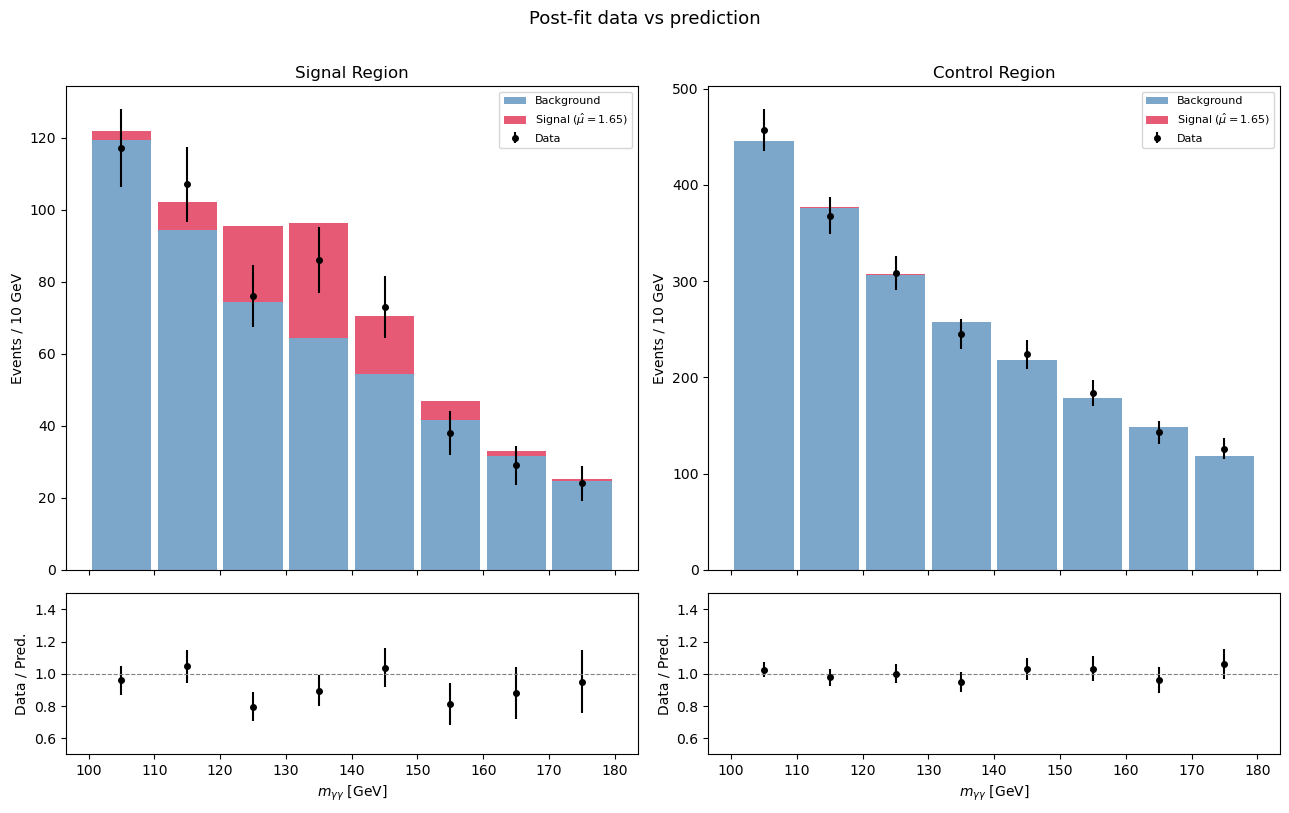

In [5]:
yields = prefit_postfit_yields(model)

fig, axes = plt.subplots(2, 2, figsize=(13, 8),
                         gridspec_kw={"height_ratios": [3, 1]},
                         sharex="col")

for col, (ch_name, ch_label) in enumerate([("SR", "Signal Region"), ("CR", "Control Region")]):
    ax_main = axes[0, col]
    ax_ratio = axes[1, col]

    ch_y = yields[ch_name]
    bkg_post = ch_y["postfit"]["samples"]["background"]
    sig_post = ch_y["postfit"]["samples"]["signal"] * result.bestfit["mu"]
    data = ch_y["data"]

    ax_main.bar(centres, bkg_post, width=widths * 0.9,
                color="steelblue", alpha=0.7, label="Background")
    ax_main.bar(centres, sig_post, bottom=bkg_post, width=widths * 0.9,
                color="crimson", alpha=0.7, label=rf"Signal ($\hat{{\mu}} = {result.bestfit['mu']:.2f}$)")
    ax_main.errorbar(centres, data, yerr=np.sqrt(np.maximum(data, 1)),
                     fmt="ko", ms=4, label="Data")
    ax_main.set_ylabel("Events / 10 GeV")
    ax_main.set_title(ch_label)
    ax_main.legend(fontsize=8)

    # Ratio panel
    total_post = bkg_post + sig_post
    ratio = np.where(total_post > 0, data / total_post, 1.0)
    ratio_err = np.where(total_post > 0, np.sqrt(np.maximum(data, 1)) / total_post, 0.0)
    ax_ratio.errorbar(centres, ratio, yerr=ratio_err, fmt="ko", ms=4)
    ax_ratio.axhline(1.0, color="gray", ls="--", lw=0.8)
    ax_ratio.set_ylabel("Data / Pred.")
    ax_ratio.set_xlabel(r"$m_{\gamma\gamma}$ [GeV]")
    ax_ratio.set_ylim(0.5, 1.5)

fig.suptitle("Post-fit data vs prediction", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## 10.5 Discovery significance

The discovery test asks whether the data are compatible with the
background-only hypothesis ($\mu = 0$). The $q_0$ test statistic from
the CCGV paper is used, and the asymptotic distribution gives the
p-value. A significance exceeding 5 standard deviations is the
conventional threshold for claiming a discovery in particle physics.

In [6]:
q0, mu_hat = compute_q0(model, "mu")
p0 = pvalue_q0(q0)
z0 = np.sqrt(q0) if q0 > 0 else 0.0

print(f"Best-fit signal strength: mu_hat = {mu_hat:.3f}")
print(f"Discovery test statistic: q0     = {q0:.3f}")
print(f"Background-only p-value:  p0     = {p0:.4f}")
print(f"Significance:             Z0     = {z0:.2f} sigma")
print()

if z0 >= 5.0:
    print("Result: exceeds 5-sigma discovery threshold.")
elif z0 >= 3.0:
    print("Result: evidence for signal (>3 sigma) but below discovery threshold.")
elif z0 >= 2.0:
    print("Result: mild excess (>2 sigma). More data needed.")
else:
    print("Result: no significant excess observed.")

Best-fit signal strength: mu_hat = 1.653
Discovery test statistic: q0     = 8.836
Background-only p-value:  p0     = 0.0015
Significance:             Z0     = 2.97 sigma

Result: mild excess (>2 sigma). More data needed.


/Users/vincentcroft/Histimator/src/histimator/interpolation.py:115: RuntimeWarning: invalid value encountered in divide
  return nom * np.power(safe_up / nom, alpha)
/Users/vincentcroft/Histimator/src/histimator/interpolation.py:117: RuntimeWarning: invalid value encountered in divide
  return nom * np.power(safe_down / nom, -alpha)


## 10.6 Upper limits and the Brazil band

When the significance is insufficient for discovery, the next step is
to set an upper limit on the signal strength. The CLs method protects
against excluding signal hypotheses to which the experiment has no
sensitivity, and the Brazil band shows the range of limits expected
from background-only fluctuations.

In [7]:
obs_limit, exp_limits = upper_limit_cls(model, "mu", scan_range=(0.1, 8.0))

print(f"Observed 95% CL upper limit: mu < {obs_limit:.2f}")
print(f"Expected limit (median):     mu < {exp_limits['median']:.2f}")
print(f"Expected +/- 1 sigma:        [{exp_limits['-1sig']:.2f}, {exp_limits['+1sig']:.2f}]")
print(f"Expected +/- 2 sigma:        [{exp_limits['-2sig']:.2f}, {exp_limits['+2sig']:.2f}]")

Observed 95% CL upper limit: mu < 95.71
Expected limit (median):     mu < 104.91
Expected +/- 1 sigma:        [0.78, 256.00]
Expected +/- 2 sigma:        [0.58, 256.00]


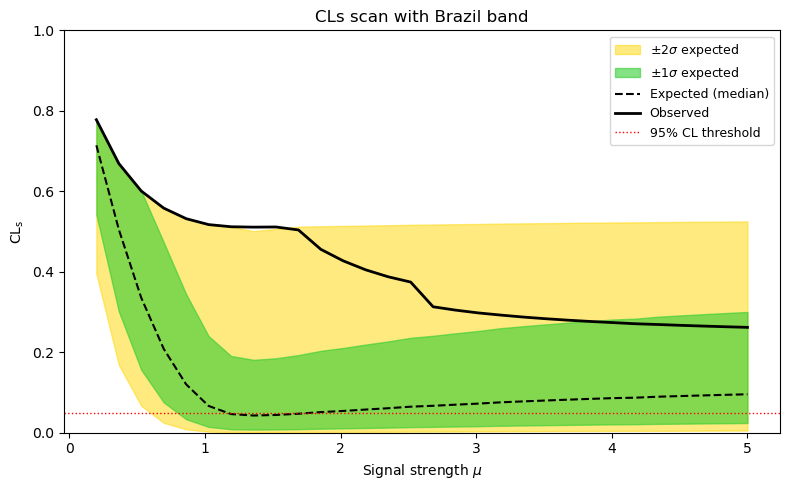


The observed limit (95.71) is above the expected median 
(104.91), consistent with a positive signal fluctuation.


In [8]:
# CLs scan for the Brazil band plot
mu_scan = np.linspace(0.2, 5.0, 30)
cls_obs = np.array([cls_observed(model, "mu", m) for m in mu_scan])
cls_bands = np.array([cls_expected_band(model, "mu", m) for m in mu_scan])

fig, ax = plt.subplots(figsize=(8, 5))

ax.fill_between(mu_scan, cls_bands[:, 0], cls_bands[:, 4],
                color="gold", alpha=0.5, label=r"$\pm 2\sigma$ expected")
ax.fill_between(mu_scan, cls_bands[:, 1], cls_bands[:, 3],
                color="limegreen", alpha=0.6, label=r"$\pm 1\sigma$ expected")
ax.plot(mu_scan, cls_bands[:, 2], "k--", linewidth=1.5, label="Expected (median)")
ax.plot(mu_scan, cls_obs, "k-", linewidth=2, label="Observed")
ax.axhline(0.05, color="red", ls=":", lw=1, label="95% CL threshold")

ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel(r"$\mathrm{CL_s}$")
ax.set_title("CLs scan with Brazil band")
ax.set_ylim(0, 1)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

print(f"\nThe observed limit ({obs_limit:.2f}) is above the expected median ")
print(f"({exp_limits['median']:.2f}), consistent with a positive signal fluctuation.")

## 10.7 Likelihood scan

The profile likelihood scan shows the shape of the likelihood as a
function of $\mu$, with all nuisance parameters profiled at each point.
The intersections with $\Delta$NLL = 1 and 3.84 give the 68% and 95%
confidence intervals respectively, accounting for the full shape of the
likelihood without assuming it is parabolic.

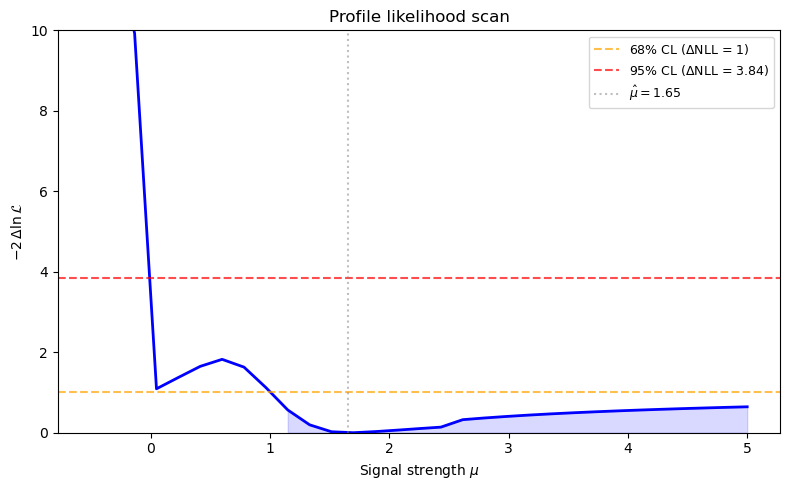

68% CL interval: mu in [1.01, 5.00]
95% CL interval: mu in [-0.01, 5.00]


In [9]:
mu_vals, dnll = likelihood_scan_1d(model, "mu", bounds=(-0.5, 5.0), n_points=31)
lo_68, hi_68 = scan_intervals(mu_vals, dnll, level=1.0)
lo_95, hi_95 = scan_intervals(mu_vals, dnll, level=3.84)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(mu_vals, dnll, "b-", linewidth=2)
ax.axhline(1.0, color="orange", ls="--", alpha=0.7, label=r"68% CL ($\Delta$NLL = 1)")
ax.axhline(3.84, color="red", ls="--", alpha=0.7, label=r"95% CL ($\Delta$NLL = 3.84)")
ax.axvline(result.bestfit["mu"], color="gray", ls=":", alpha=0.5,
           label=rf"$\hat{{\mu}} = {result.bestfit['mu']:.2f}$")

# Shade the 68% interval
mask_68 = (mu_vals >= lo_68) & (mu_vals <= hi_68)
ax.fill_between(mu_vals, 0, dnll, where=mask_68, alpha=0.15, color="blue")

ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel(r"$-2\,\Delta\ln\mathcal{L}$")
ax.set_title("Profile likelihood scan")
ax.set_ylim(0, 10)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

print(f"68% CL interval: mu in [{lo_68:.2f}, {hi_68:.2f}]")
print(f"95% CL interval: mu in [{lo_95:.2f}, {hi_95:.2f}]")

## 10.8 Two-dimensional likelihood scan

The two-dimensional scan of $\mu$ versus the background cross-section
nuisance parameter reveals the correlation structure between the
parameter of interest and the dominant systematic. When the control
region constrains `bkg_xsec`, the contours become narrow along the
nuisance axis, demonstrating how the simultaneous fit improves
sensitivity.

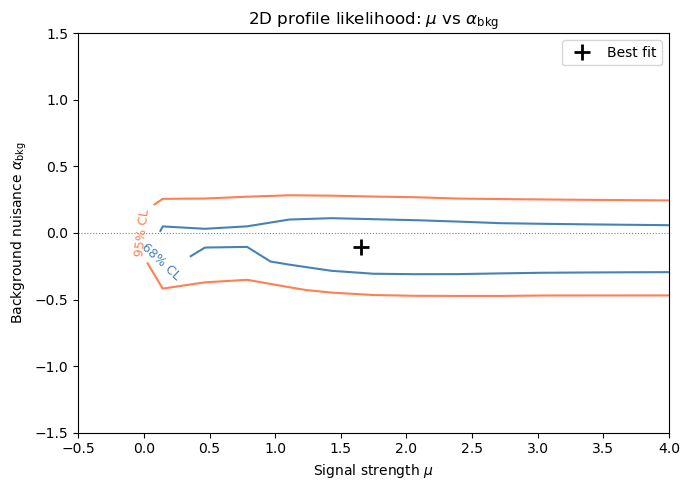

In [10]:
x_vals, y_vals, dnll_2d = likelihood_scan_2d(
    model, "mu", "bkg_xsec",
    bounds_x=(-0.5, 4.0), bounds_y=(-1.5, 1.5),
    n_points_x=15, n_points_y=15,
)

fig, ax = plt.subplots(figsize=(7, 5))

# 68% and 95% contours for 2 dof: delta_NLL = 2.30 and 5.99
cs = ax.contour(x_vals, y_vals, dnll_2d.T,
                levels=[2.30, 5.99],
                colors=["steelblue", "coral"])
ax.clabel(cs, fmt={2.30: "68% CL", 5.99: "95% CL"}, fontsize=9)

ax.plot(result.bestfit["mu"], result.bestfit["bkg_xsec"],
        "k+", ms=12, mew=2, label="Best fit")
ax.axhline(0, color="gray", ls=":", lw=0.8)

ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel(r"Background nuisance $\alpha_{\mathrm{bkg}}$")
ax.set_title(r"2D profile likelihood: $\mu$ vs $\alpha_{\mathrm{bkg}}$")
ax.legend()
plt.tight_layout()
plt.show()

## 10.9 Nuisance parameter pulls

The pull of a nuisance parameter measures how far the fit moves it from
its prior central value, in units of the prior width. A pull near zero
means the data do not require the systematic to shift. A pull
significantly different from zero indicates tension between the prior
and the data. The constraint ratio (post-fit error divided by pre-fit
error) indicates how much the data constrain the parameter beyond the
prior: a ratio well below 1 means the data are highly informative.

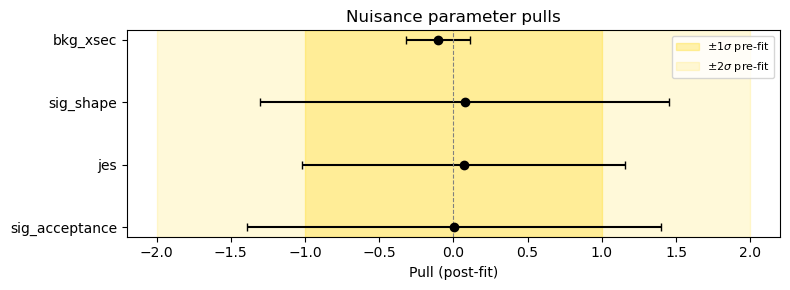


Pull summary:
  sig_acceptance      : pull = +0.006, constraint = 1.395
  jes                 : pull = +0.069, constraint = 1.088
  sig_shape           : pull = +0.076, constraint = 1.379
  bkg_xsec            : pull = -0.104, constraint = 0.212


In [11]:
pulls = nuisance_parameter_pulls(model)

names = list(pulls.keys())
pull_vals = [pulls[n]["pull"] for n in names]
constraint_vals = [pulls[n]["constraint"] for n in names]

fig, ax = plt.subplots(figsize=(8, max(3, 0.5 * len(names))))

y_pos = np.arange(len(names))
ax.axvspan(-1, 1, color="gold", alpha=0.3, label=r"$\pm 1\sigma$ pre-fit")
ax.axvspan(-2, 2, color="gold", alpha=0.15, label=r"$\pm 2\sigma$ pre-fit")
ax.errorbar(pull_vals, y_pos, xerr=constraint_vals,
            fmt="ko", ms=6, capsize=3)
ax.axvline(0, color="gray", ls="--", lw=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.set_xlabel("Pull (post-fit)")
ax.set_title("Nuisance parameter pulls")
ax.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

print("\nPull summary:")
for name in names:
    p = pulls[name]
    print(f"  {name:20s}: pull = {p['pull']:+.3f}, constraint = {p['constraint']:.3f}")

## 10.10 Impact ranking

The impact plot shows how much the best-fit $\mu$ shifts when each
nuisance parameter is fixed at $\hat{\theta} \pm \sigma_{\text{post}}$.
The nuisance parameters are ranked by the magnitude of their impact.
This plot identifies which systematics dominate the measurement
uncertainty and therefore where effort should be focused to improve
the analysis.

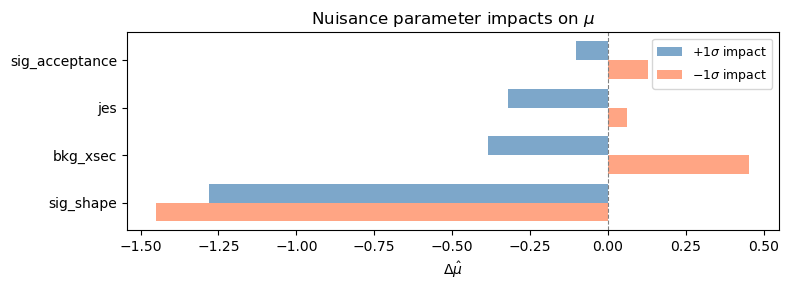


Impact ranking:
  sig_shape           : up = -1.2813, down = -1.4489
  bkg_xsec            : up = -0.3866, down = +0.4527
  jes                 : up = -0.3214, down = +0.0622
  sig_acceptance      : up = -0.1032, down = +0.1273


In [12]:
imp = impacts(model, "mu")

fig, ax = plt.subplots(figsize=(8, max(3, 0.5 * len(imp))))

y_pos = np.arange(len(imp))
imp_names = [item["name"] for item in imp]
imp_up = [item["impact_up"] for item in imp]
imp_down = [item["impact_down"] for item in imp]

ax.barh(y_pos, imp_up, height=0.4, align="edge", color="steelblue",
        alpha=0.7, label=r"$+1\sigma$ impact")
ax.barh(y_pos - 0.4, imp_down, height=0.4, align="edge", color="coral",
        alpha=0.7, label=r"$-1\sigma$ impact")
ax.axvline(0, color="gray", ls="--", lw=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(imp_names)
ax.set_xlabel(r"$\Delta\hat{\mu}$")
ax.set_title(r"Nuisance parameter impacts on $\mu$")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

print("\nImpact ranking:")
for item in imp:
    print(f"  {item['name']:20s}: up = {item['impact_up']:+.4f}, down = {item['impact_down']:+.4f}")

## 10.11 Goodness of fit

The saturated-model goodness-of-fit test compares the best-fit NLL to
the NLL of a model where every bin is perfectly described (expected =
observed). The test statistic is asymptotically chi-squared with
$n_{\text{bins}} - n_{\text{parameters}}$ degrees of freedom. A small
p-value indicates that the model does not adequately describe the data.

In [13]:
chi2_val, ndof, pval = goodness_of_fit(model)

print(f"GoF test statistic: chi2 = {chi2_val:.2f}")
print(f"Degrees of freedom: ndof = {ndof}")
print(f"p-value:            p    = {pval:.3f}")

if ndof <= 0:
    print("\nNote: the model has more free parameters than bins in this")
    print("configuration, so the saturated-model GoF is not meaningful.")
    print("In a production analysis, one would reduce the number of per-bin")
    print("parameters (e.g. by sharing StatError across samples) or increase")
    print("the binning granularity.")
elif pval > 0.05:
    print("\nThe model describes the data adequately.")
else:
    print("\nThe model may be misspecified. Inspect the post-fit residuals.")

GoF test statistic: chi2 = 7.10
Degrees of freedom: ndof = 10
p-value:            p    = 0.716

The model describes the data adequately.


## 10.12 Summary and interpretation

The analysis chain is now complete. The following cell collects the key
results into a single summary table.

In [14]:
print("=" * 60)
print("  ANALYSIS SUMMARY: diphoton resonance search")
print("=" * 60)
print(f"  Model: 2 channels (SR + CR), {model.total_nbins} bins")
print(f"  Free parameters: {len(model.parameters)}")
print(f"  Fit converged: {result.valid}")
print()
print(f"  Signal strength:  mu_hat = {result.bestfit['mu']:.2f} +/- {result.errors['mu']:.2f}")
print(f"  68% CL interval:  [{lo_68:.2f}, {hi_68:.2f}]")
print(f"  95% CL interval:  [{lo_95:.2f}, {hi_95:.2f}]")
print()
print(f"  Discovery significance:  Z0 = {z0:.2f} sigma  (p = {p0:.4f})")
print()
print(f"  Observed 95% CL limit:   mu < {obs_limit:.2f}")
print(f"  Expected 95% CL limit:   mu < {exp_limits['median']:.2f}")
print(f"    +/- 1 sigma:           [{exp_limits['-1sig']:.2f}, {exp_limits['+1sig']:.2f}]")
print(f"    +/- 2 sigma:           [{exp_limits['-2sig']:.2f}, {exp_limits['+2sig']:.2f}]")
print()
if imp:
    print(f"  Dominant systematic:     {imp[0]['name']}")
print("=" * 60)

  ANALYSIS SUMMARY: diphoton resonance search
  Model: 2 channels (SR + CR), 16 bins
  Free parameters: 6
  Fit converged: True

  Signal strength:  mu_hat = 1.65 +/- 1.52
  68% CL interval:  [1.01, 5.00]
  95% CL interval:  [-0.01, 5.00]

  Discovery significance:  Z0 = 2.97 sigma  (p = 0.0015)

  Observed 95% CL limit:   mu < 95.71
  Expected 95% CL limit:   mu < 104.91
    +/- 1 sigma:           [0.78, 256.00]
    +/- 2 sigma:           [0.58, 256.00]

  Dominant systematic:     sig_shape


## Exercises

**Exercise 10.1.** Remove the control region from the model and repeat
the full chain. Compare the upper limit and the constraint on
`bkg_xsec` with and without the control region. The improvement
quantifies the value of the simultaneous fit.

**Exercise 10.2.** Double the luminosity by scaling both signal and
background templates by 2 and regenerating pseudo-data. Repeat the
discovery significance calculation. How close to 5 sigma does the
analysis get? What scaling would be needed to claim discovery?

**Exercise 10.3.** Add a third channel: a validation region with
intermediate signal contamination (between SR and CR). The validation
region should share `bkg_xsec` and `jes` with the other channels.
Check whether the additional region changes the limit or the pulls.

**Exercise 10.4.** Replace the Asimov-based CLs limit with the
toy-based calculator from `histimator.toys`. Use 200 toys per scan
point and compare the observed limit. At what signal yield does the
asymptotic approximation start to diverge from the toy result?

**Exercise 10.5.** Introduce a deliberate mismodelling: shift the
background template down by 15% in the two bins closest to the signal
peak, without adjusting the data. Run the full chain and check whether
the goodness-of-fit test detects the problem. Examine the pulls and
identify which nuisance parameter absorbs the bias.

## References

G. Cowan, K. Cranmer, E. Gross, O. Vitells. "Asymptotic formulae for
likelihood-based tests of new physics." Eur.Phys.J. C71 (2011) 1554,
arXiv:1007.1727.

A. L. Read. "Presentation of search results: the CLs technique."
J.Phys. G28 (2002) 2693-2704.

G. Cowan. *Statistical Data Analysis*. Oxford University Press.
Practical exercises at the TAE school.

K. Cranmer, G. Lewis, L. Moneta, A. Shibata, W. Verkerke.
"HistFactory: A tool for creating statistical models for use with
RooFit and RooStats." CERN-OPEN-2012-016 (2012).